In [1]:
import pandas as pd
import math
#import autocomplete
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter('ignore') 


#importing required Modules and Algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler, MinMaxScaler, FunctionTransformer,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_val_predict
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
def model_performance(model,x,y):
    pred=model.predict(x)
    print("Model Performance")
    print("--------------------------")
    print ("Accuracy:",accuracy_score(y,pred))
    print ("precision:", precision_score(y,pred))
    print ("Recall:",recall_score(y,pred))
    print ("F1 Score:",f1_score(y,pred))
def model_performance_scores(model,x,y):
    pred=model.predict(x)
    return accuracy_score(y,pred), precision_score(y,pred),recall_score(y,pred),f1_score(y,pred)
def display_AUC_ROC():
    print('Area Under ROC')
    print('---------------')
    print('LogisticRegression:',roc_auc_score(y_train, y_logitint_scores).round(3))
    print('DecisionTree:',roc_auc_score(y_train, y_dt_scores).round(3))
    print('RandomForest:',roc_auc_score(y_train, y_rf_scores).round(3))
    print('XGBoost:',roc_auc_score(y_train, y_xgb_scores).round(3))
    plt.figure(figsize=(8,6))
    plt.plot(fpr_logit,tpr_logit,label="Logistic regression")
    plt.plot(fpr_dt,tpr_dt,label="Decisiontree")
    plt.plot(fpr_rf,tpr_rf,label="Random Forest")
    plt.plot(fpr_xgb,tpr_xgb,label="Gradient Boosting")
    plt.plot([0, 1], [0, 1], 'k--'),plt.axis([0, 1, 0, 1.1])
    plt.xlabel('False Positive Rate') ,plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right'),plt.title('Recieve operator curve')

In [3]:
#loading
ouc_df=pd.read_csv("oucdata1.csv")
#eleminating
oucdf=ouc_df.drop(columns=['READING_TS_LTZ','Unnamed: 0','METER_SCHEDULE','IS_BILLING_FLG','COLLECTION_TS_LTZ','INTERVAL_SECONDS','NUM_INTERVAL','SUM_INTERVALS','DIRECTION','DATETIME_KEYI','COLLECTOR_KEY','SEQ','SP_ID','LONGITUDE','LATITUDE','WATER_ONLY_FLG','INSTALLED_REMOVED','LOCATION','UOM'])
#sampling
oucdf_sample=oucdf.sample(n=750000,random_state=123)
#dummy variables
model_data=pd.get_dummies(oucdf_sample)
X_full=model_data.drop('STATUS_CATEGORY',axis=1)
y_full=model_data.loc[:,'STATUS_CATEGORY']
#Splitting
X, X_test, y, y_test= train_test_split(X_full,y_full,test_size=0.2,random_state =123)
X_train, X_valid, y_train, y_valid= train_test_split(X,y,test_size=0.2,random_state =124)

In [12]:
#logistic Regression
log_reg=LogisticRegression(solver='liblinear')
log_reg.fit(X_train,y_train)
logistic_train_scores=list(model_performance_scores(log_reg,X_train,y_train))
logistic_test_scores=list(model_performance_scores(log_reg,X_test,y_test))
y_logitint_predict_prob=log_reg.predict_proba(X_train)
y_logitint_scores=y_logitint_predict_prob[:,1]
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_train, y_logitint_scores)


#Decesion Tree
dt=DecisionTreeClassifier(max_depth=4)
dt.fit(X_train,y_train)
dt_train_scores=list(model_performance_scores(dt,X_train,y_train))
dt_test_scores=list(model_performance_scores(dt,X_test,y_test))
y_dt_predict_prob=dt.predict_proba(X_train)
y_dt_scores=y_dt_predict_prob[:,1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_train, y_dt_scores)


#Random Forest
rf = RandomForestClassifier(max_depth=3,n_estimators=500,random_state=4)
rf.fit(X_train,y_train)
rf_test_scores=list(model_performance_scores(rf,X_test,y_test))
y_random_predict_prob=rf.predict_proba(X_train)
y_rf_scores=y_random_predict_prob[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_rf_scores)

#XGboost
XGB_model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=10000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10
                    )
XGB_model.fit(X_train,y_train)
xgb_train_scores=list(model_performance_scores(XGB_model,X_train,y_train))
xgb_test_scores=list(model_performance_scores(XGB_model,X_test,y_test))
y_xgb_predict_prob=XGB_model.predict_proba(X_train)
y_xgb_scores=y_xgb_predict_prob[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_xgb_scores)

[13:47:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [13]:
scores=pd.DataFrame([logistic_test_scores,
                   dt_test_scores,rf_test_scores,
                    xgb_test_scores])
scores.columns=['Accuracy','Precision','Recall','F1 Score']
scores.index=['logistic_test',
              'DecisionTree_test',
              'RandomForest_test',
               'XGB_Test']
scores

,Accuracy,Precision,Recall,F1 Score
logistic_test,0.977633,0.000000,0.000000,0.000000
DecisionTree_test,0.994107,0.968525,0.761252,0.852470
RandomForest_test,0.989847,0.970226,0.563338,0.712804
XGB_Test,0.994107,0.968525,0.761252,0.852470


Area Under ROC
---------------
LogisticRegression: 0.665
DecisionTree: 0.905
RandomForest: 0.92
XGBoost: 0.971


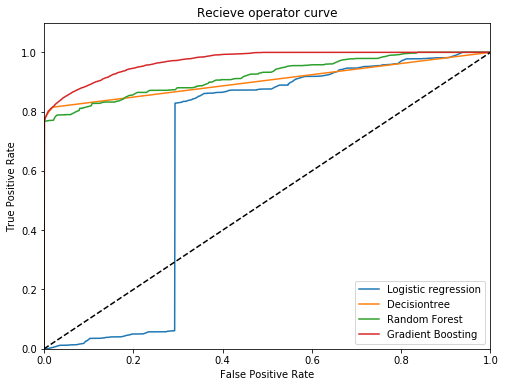

In [14]:
display_AUC_ROC()

## Smoteen

In [4]:

#logistic Regression
model=LogisticRegression(solver='liblinear')
log_reg = make_pipeline(SMOTE(random_state=12), model)
log_reg.fit(X_train,y_train)
logistic_train_scores=list(model_performance_scores(log_reg,X_train,y_train))
logistic_test_scores=list(model_performance_scores(log_reg,X_valid,y_valid))
y_logitint_predict_prob=log_reg.predict_proba(X_train)
y_logitint_scores=y_logitint_predict_prob[:,1]
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_train, y_logitint_scores)


#Decesion Tree
model=DecisionTreeClassifier(max_depth=4)
dt = make_pipeline(SMOTE(random_state=12), model)
dt.fit(X_train,y_train)
dt_train_scores=list(model_performance_scores(dt,X_train,y_train))
dt_test_scores=list(model_performance_scores(dt,X_valid,y_valid))
y_dt_predict_prob=dt.predict_proba(X_train)
y_dt_scores=y_dt_predict_prob[:,1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_train, y_dt_scores)


#Random Forest
model= RandomForestClassifier(max_depth=3,n_estimators=500,random_state=4)
rf = make_pipeline(SMOTE(random_state=12), model)
rf.fit(X_train,y_train)
rf_test_scores=list(model_performance_scores(rf,X_valid,y_valid))
y_random_predict_prob=rf.predict_proba(X_train)
y_rf_scores=y_random_predict_prob[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_rf_scores)

#XGboost
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=10000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10
                    )

XGB_model = make_pipeline(SMOTE(random_state=12), model)
XGB_model.fit(X_train,y_train)
xgb_train_scores=list(model_performance_scores(XGB_model,X_train,y_train))
xgb_test_scores=list(model_performance_scores(XGB_model,X_valid,y_valid))
y_xgb_predict_prob=XGB_model.predict_proba(X_train)
y_xgb_scores=y_xgb_predict_prob[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_xgb_scores)

[13:00:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [5]:
scores=pd.DataFrame([logistic_test_scores,
                   dt_test_scores,rf_test_scores,
                    xgb_test_scores])
scores.columns=['Accuracy','Precision','Recall','F1 Score']
scores.index=['logistic_test',
              'DecisionTree_test',
              'RandomForest_test',
               'XGB_Test']
scores

,Accuracy,Precision,Recall,F1 Score
logistic_test,0.776583,0.076209,0.826302,0.139547
DecisionTree_test,0.977092,0.486579,0.812999,0.608795
RandomForest_test,0.994550,0.976386,0.770049,0.861028
XGB_Test,0.962317,0.349801,0.836944,0.493390


Area Under ROC
---------------
LogisticRegression: 0.853
DecisionTree: 0.905
RandomForest: 0.938
XGBoost: 0.974


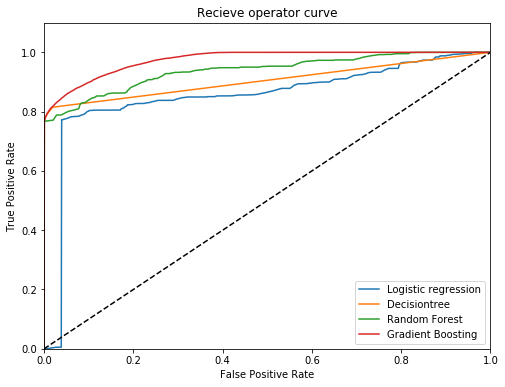

In [6]:
display_AUC_ROC()